In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import spacegan_utils
import spacegan_method
import spacegan_selection
import spacegan_config
import warnings
warnings.simplefilter("ignore")
cur_dir = os.getcwd()

C:\Users\Koshiyama\Anaconda3\lib\site-packages\libpysal\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
C:\Users\Koshiyama\Anaconda3\lib\site-packages\pysal\lib\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')


## Dataset

Text(0.5,1,'Observed')

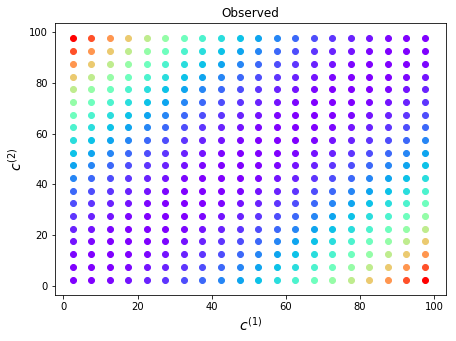

In [2]:
# dataset
df = pd.read_csv("grid.csv")
coord_vars = ["longitude", "latitude"]
cond_vars = ["z"] + coord_vars
output_vars = ["y"]
neighbours = 8

# plotting
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
gen_seq = df[["y"]].values.astype(float)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax1.scatter(lat, long, color=c)
ax1.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax1.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax1.set_title("Observed")

# SpaceGAN Config

## Training config

In [3]:
# problem configuration
results_path = "./Results/"
prob_config = {"epochs": 5001,
               "batch_size": 100,
               "device": torch.device("cuda"),
               "cond_dim": len(cond_vars) + neighbours,  # conditional information size
               "output_dim": len(output_vars),  # size of output
               "noise_dim": len(cond_vars) + neighbours,  # size of noise
               "noise_type": spacegan_utils.gaussian,  # type of noise and dimension used
               "noise_params": None,  # other params for noise (loc, scale, etc.) pass as a dict
               "scale_x": StandardScaler(),  # a sklearn.preprocessing scaling method
               "scale_y": StandardScaler(),  # a sklearn.preprocessing scaling method
               "print_results": False
               }

## Networks

In [4]:
# Generator architecture
class Generator(nn.Module):
    def __init__(self, cond_dim, noise_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(cond_dim + noise_dim, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim)
        )

    def forward(self, z, cond_info):
        input_data = torch.cat([z, cond_info], dim=1).float()
        data = self.model(input_data).float()
        return data

# additional Generator params
prob_config["gen_opt"] = torch.optim.SGD
prob_config["gen_opt_params"] = {"lr": 0.01}

# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, output_dim, cond_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(output_dim + cond_dim, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, data, cond_info):
        input_data = torch.cat([data, cond_info], dim=1).float()
        validity = self.model(input_data).float()
        return validity
    
# additional Discriminator params
prob_config["disc_opt"] = torch.optim.SGD
prob_config["disc_opt_params"] = {"lr": 0.01}

# loss function
prob_config["adversarial_loss"] = torch.nn.BCELoss()

## Selection config

In [5]:
# checkpointing configuration
check_config = {
    "check_interval": 100,  # for model checkpointing
    "generate_image": False,
    "n_samples": 100,
    "perf_metrics": {"RMSE": spacegan_utils.rmse,
                     "MIE": spacegan_utils.mie,
                     },
    "pf_metrics_setting": {
        "RMSE": {"metric_level": "agg_metrics",
             "rank_function": np.argmin,
             "agg_function": lambda x: np.array(x)
             },
        "MIE": {"metric_level": "agg_metrics",
                "rank_function": np.argmin,
                "agg_function": lambda x: np.array(x)
               },
    },
    "agg_funcs": {"avg": np.mean,
                  "std": np.std
                 },
    "sample_metrics": False,
    "agg_metrics": True
}

# SpaceGAN - Main

## Training

In [ ]:
os.chdir(results_path)

# neighbours
df, neighbour_list = spacegan_utils.get_neighbours_featurize(df, coord_vars, output_vars, neighbours)

# data structures
target = df[output_vars].values
cond_input = df[cond_vars + neighbour_list].values
coord_input = df[coord_vars].values
prob_config["output_labels"] = output_vars
prob_config["input_labels"] = cond_vars + neighbour_list

# pre-instantiation
disc_method = Discriminator(prob_config["output_dim"], prob_config["cond_dim"])
disc_method.to(prob_config["device"])
gen_method = Generator(prob_config["cond_dim"], prob_config["noise_dim"], prob_config["output_dim"])
gen_method.to(prob_config["device"])

# training SpaceGAN
spacegan = spacegan_method.SpaceGAN(prob_config, check_config, disc_method, gen_method)
spacegan.train(x_train=cond_input, y_train=target, coords=coord_input)

# export final model and data
spacegan.checkpoint_model(spacegan.epochs) 
spacegan.df_losses.to_pickle("grid_spaceganlosses.pkl.gz")

## Selection - Best

In [ ]:
# computing metrics
gan_metrics = spacegan_selection.compute_metrics(target, cond_input, prob_config, check_config, coord_input, neighbours)

# selecting and sampling gan
for criteria in list(check_config["perf_metrics"].keys()):
    # find best config
    criteria_info = check_config["pf_metrics_setting"][criteria]
    perf_metrics = gan_metrics[criteria_info["metric_level"]]
    perf_values = criteria_info["agg_function"](perf_metrics[[criteria]])
    best_config = perf_metrics.index[criteria_info["rank_function"](perf_values)]

    # get and set best space gan
    best_spacegan = spacegan_selection.get_spacegan_config(int(best_config), prob_config, check_config, cond_input, target)
    # training samples
    gan_samples_df = pd.DataFrame(index=range(cond_input.shape[0]), columns=cond_vars + neighbour_list + output_vars)
    gan_samples_df[cond_vars + neighbour_list] = cond_input
    gan_samples_df[output_vars] = target
    for i in range(check_config["n_samples"]):
        gan_samples_df["sample_" + str(i)] = best_spacegan.predict(gan_samples_df[cond_vars + neighbour_list])

    # export results
    gan_samples_df.to_pickle("grid_" + criteria + ".pkl.gz")
gan_metrics["agg_metrics"].to_pickle("grid_checkmetrics.pkl.gz")

# show highlights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
gan_metrics["agg_metrics"].plot(ax=ax1)

# generate chart
gen_seq = gan_samples_df[["sample_" + str(x) for x in range(100)]].mean(axis=1)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax2.scatter(lat, long, color=c)
ax2.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax2.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax2.set_title("SpaceGAN - Best " + criteria)

## Selection - Pick the one you like!

In [ ]:
iteration = 500

# get and set best space gan
iter_spacegan = spacegan_selection.get_spacegan_config(iteration, prob_config, check_config, cond_input, target)

# training samples
gan_samples_df = pd.DataFrame(index=range(cond_input.shape[0]), columns=cond_vars + neighbour_list + output_vars)
gan_samples_df[cond_vars + neighbour_list] = cond_input
gan_samples_df[output_vars] = target
for i in range(check_config["n_samples"]):
    gan_samples_df["sample_" + str(i)] = iter_spacegan.predict(gan_samples_df[cond_vars + neighbour_list])
    
# generate chart
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
gen_seq = gan_samples_df[["sample_" + str(x) for x in range(100)]].mean(axis=1)
norm_gan_mean = (gen_seq - min(gen_seq)) / (max(gen_seq) - min(gen_seq))
colors = cm.rainbow(norm_gan_mean)

# plotting
for lat, long, c in zip(df["latitude"], df["longitude"], colors):
    ax1.scatter(lat, long, color=c)
ax1.set_xlabel(r'$c^{(1)}$', fontsize=14)
ax1.set_ylabel(r'$c^{(2)}$', fontsize=14)
ax1.set_title("SpaceGAN - Iteration " + str(iteration))